Created: 2020.07.22

Modified: 2020.07.26

In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

import random
import pandas as pd
from pathlib import Path

import sys
sys.path.append('../functions')
import functions32 as f32

# 2D AXIAL

In [120]:
folder_path = Path('/data-10tb/shared/skull/axial-2d/')

df_full = pd.read_csv(folder_path/'bias_mask-test-val-axial-2d.csv')
print(df_full.shape)
#df_full.head()

(425766, 6)


#### Select part of the whole df

In [121]:
df = f32.split_data(df_full, pct_rand_both=0.003, nr_beg_both=None)
df.shape

Original df=425766:	train=983, val=294,	train+val=1277, df*pct_rand_both=1277.3


(1277, 6)

#### Create a DataBunch v.1

In [122]:
codes = np.loadtxt(folder_path/'codes.txt', dtype=str); codes

array(['background', 'brain'], dtype='<U10')

In [141]:
src = SegmentationItemList.from_df(df, folder_path, cols='bias_path')\
                            .split_from_df(col='usage')\
                            .label_from_df(cols='mask_full_path', classes=codes)

In [142]:
src

LabelLists;

Train: LabelList (983 items)
x: SegmentationItemList
Image (3, 180, 240),Image (3, 211, 240),Image (3, 176, 256),Image (3, 176, 256),Image (3, 176, 256)
y: SegmentationLabelList
ImageSegment (1, 180, 240),ImageSegment (1, 211, 240),ImageSegment (1, 176, 256),ImageSegment (1, 176, 256),ImageSegment (1, 176, 256)
Path: /data-10tb/shared/skull/axial-2d;

Valid: LabelList (294 items)
x: SegmentationItemList
Image (3, 176, 256),Image (3, 158, 189),Image (3, 176, 256),Image (3, 176, 240),Image (3, 200, 241)
y: SegmentationLabelList
ImageSegment (1, 176, 256),ImageSegment (1, 158, 189),ImageSegment (1, 176, 256),ImageSegment (1, 176, 240),ImageSegment (1, 200, 241)
Path: /data-10tb/shared/skull/axial-2d;

Test: None

lista zestawu validacyjnego

LabelList (294 items)
x: SegmentationItemList
Image (3, 176, 256),Image (3, 158, 189),Image (3, 176, 256),Image (3, 176, 240),Image (3, 200, 241)
y: SegmentationLabelList
ImageSegment (1, 176, 256),ImageSegment (1, 158, 189),ImageSegment (1, 176, 256),ImageSegment (1, 176, 240),ImageSegment (1, 200, 241)
Path: /data-10tb/shared/skull/axial-2d
******************************

pierwszy element listy zestawu walidacyjnego
(Image (3, 176, 256), ImageSegment (1, 176, 256))
******************************

rozmiar obraz X z pierwszego elementu listy zestawu walidacyjnego
torch.Size([3, 176, 256])
******************************

obraz X z pierwszego elementu listy zestawu walidacyjnego



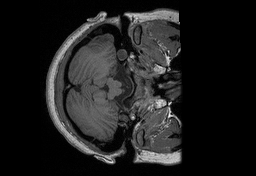

In [143]:
# src.list -> to obie listy, dla zestawu treningowego i validacyjnego
print('lista zestawu validacyjnego\n')
print(src.lists[1])
print (30*'*')
print()
print('pierwszy element listy zestawu walidacyjnego')
print(src.lists[1][0]) 
print (30*'*')
print()
print('rozmiar obraz X z pierwszego elementu listy zestawu walidacyjnego')
print(src.lists[1][0][0].shape)
print (30*'*')
print()
print('obraz X z pierwszego elementu listy zestawu walidacyjnego\n')
src.lists[1][0][0]

In [144]:
# src_size = np.array(src.lists[1][0][0].shape[1:])
# size = min(src_size) # oryg
# print(src_size)

In [145]:
size = 128
bs = 124

In [146]:
data = (src.transform(get_transforms(), size=size, tfm_y=True) 
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [147]:
data.train_ds[0]

(Image (3, 128, 128), ImageSegment (1, 128, 128))

In [130]:
# show_image(data.train_ds[1100][0])
# show_image(data.train_ds[1100][1])
# data.train_ds[1100][1].show()
# data.train_ds[1100][0].show()
# data.train_ds[1100][0]

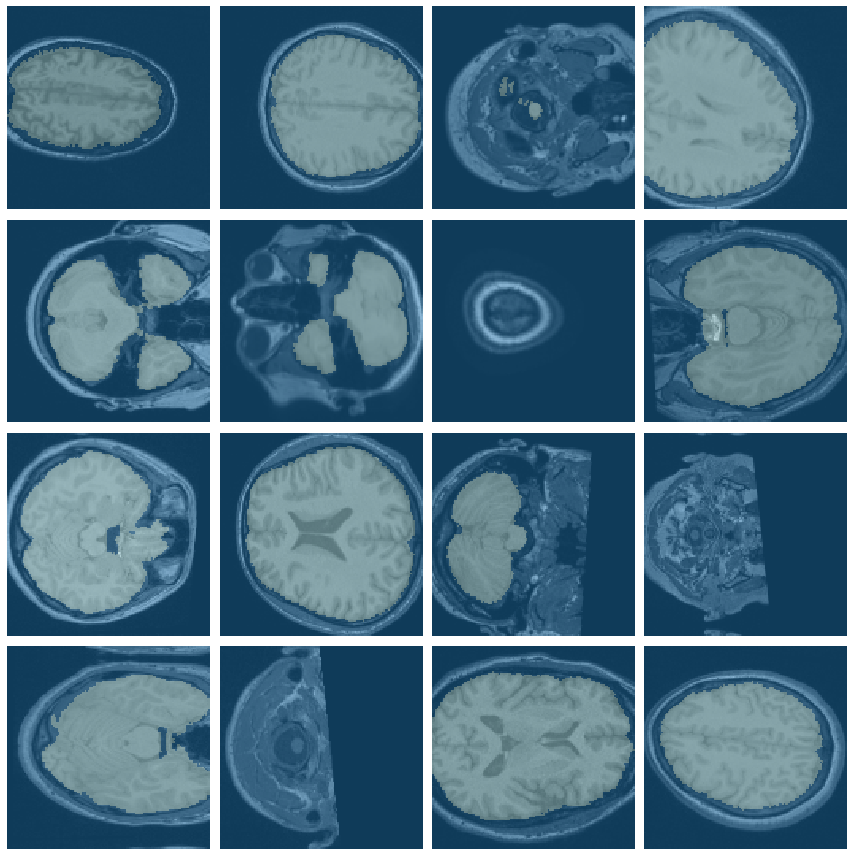

In [148]:
data.show_batch(4, figsize=(12,12))

In [132]:
# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=16
# else:           bs=8
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [132]:
# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=16
# else:           bs=8
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [149]:
wd=1e-2

In [150]:
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-05
Min loss divided by 10: 1.58E-03


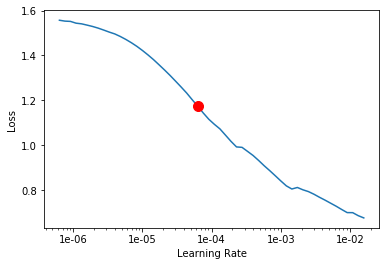

In [151]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

### LR=1e-4

In [152]:
lr=1e-4

In [153]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,1.229575,0.638709,0.008985,00:07
1,0.809528,1.005924,0.484109,00:07
2,0.630857,0.315365,0.585299,00:07
3,0.500432,0.212050,0.553412,00:07
4,0.410833,0.179553,0.613024,00:07


In [155]:
save = 0
# trening-axial/fit-one-cycle-5/lr=1e-5/freeze/splid-data-pct-rand-both-0.p003-images
sname1 = 'train-ax_foc-05_lr-slice-1e4_fr_sd-pct-rand-both-0p003'
if save:    
    learn.save(sname1)

In [156]:
learn.load(sname1);

In [157]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.140826,0.154345,0.746926,00:07
1,0.137229,0.137846,0.780447,00:07
2,0.127667,0.127644,0.767143,00:07
3,0.121551,0.094419,0.859504,00:07
4,0.116065,0.089352,0.865011,00:07
5,0.110506,0.096178,0.851762,00:07
6,0.106098,0.077010,0.882649,00:07
7,0.101871,0.078165,0.880025,00:07
8,0.097700,0.075745,0.884610,00:07
9,0.094634,0.075659,0.884933,00:07


In [158]:
sname2 = 'train-ax_foc-15_lr-slice-1e4_fr_sd-pct-rand-both-0p003'
learn.save(sname2)

In [177]:
learn.load(sname2);

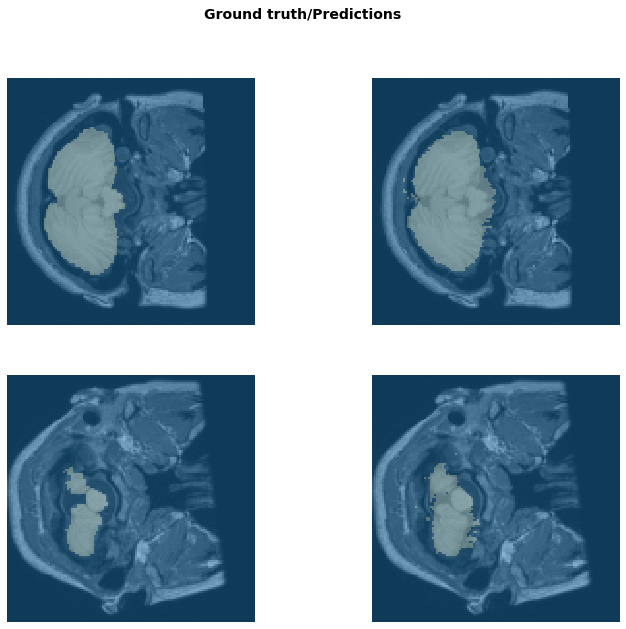

In [160]:
learn.show_results(rows=2, figsize=(12,10))

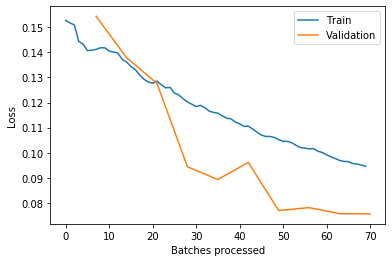

In [161]:
learn.recorder.plot_losses()

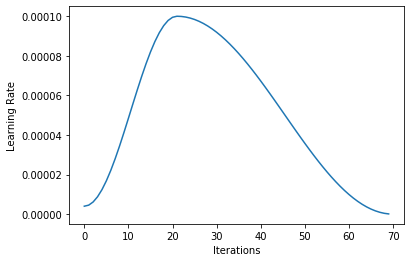

In [162]:
learn.recorder.plot_lr()

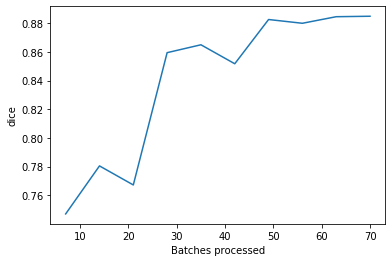

In [163]:
learn.recorder.plot_metrics()

## Predict - default size

In [166]:
#### Unfreeze

In [178]:
learn.load(sname2);

In [179]:
learn.unfreeze()

In [180]:
lrs = slice(lr/10,lr/4)

In [181]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.078731,0.075921,0.880774,00:07
1,0.077284,0.074496,0.883465,00:07
2,0.076909,0.073459,0.887187,00:07
3,0.077440,0.072534,0.878880,00:07
4,0.076902,0.068637,0.886991,00:07
5,0.074632,0.066192,0.888690,00:07
6,0.073549,0.063503,0.897208,00:07
7,0.072078,0.063023,0.898442,00:07
8,0.070534,0.062078,0.902988,00:07
9,0.069066,0.061022,0.903915,00:07


In [182]:
sname3 = 'train-ax_uf_foc-25_lr-slice-1e4_sd-pct-rand-both-0p003'
learn.save(sname3)

In [183]:
learn.load(sname3);

## [Prediction](https://docs.fast.ai/basic_train.html#fit_one_cycle)


#### v1

In [184]:
img = open_image('/data-10tb/shared/skull/axial-2d/train/IXI/IXI002-Guys-0828-T1.anat/T1_biascorr_iso_110.png')

In [198]:
print(img.shape, type(img))

torch.Size([3, 180, 240]) <class 'fastai.vision.image.Image'>


torch.Size([1, 128, 128]) <class 'fastai.vision.image.ImageSegment'>


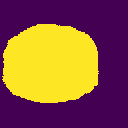

In [200]:
prediction = learn.predict(img)[0]
print(prediction.shape, type(prediction))
prediction

In [164]:
print(img.shape)
img

#### v2

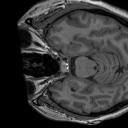

In [196]:
data = learn.data.train_ds[100][0]
data

In [209]:
pred = learn.predict(data)
print('prediction:', len(pred), type(pred), '\n')
for k in pred:
    print(k.shape, type(k))

prediction: 3 <class 'tuple'> 

torch.Size([1, 128, 128]) <class 'fastai.vision.image.ImageSegment'>
torch.Size([1, 128, 128]) <class 'torch.Tensor'>
torch.Size([2, 128, 128]) <class 'torch.Tensor'>


## Images in prediction

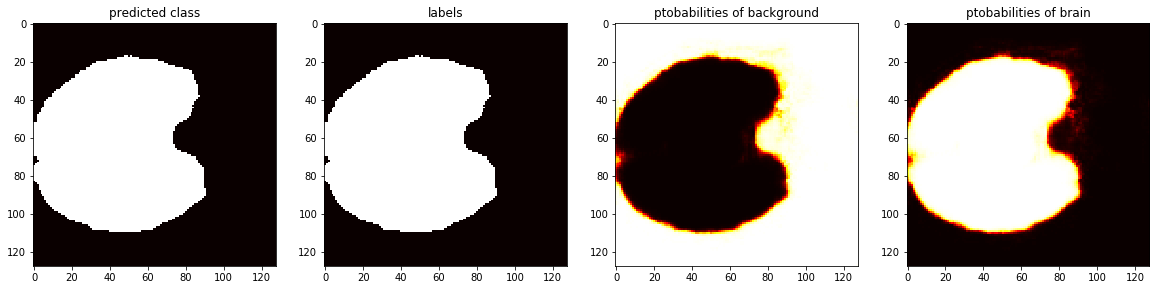

In [158]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,4,figsize=(20,8))

cm = 'hot'
p0 = pred[0].data.numpy()
ax[0].imshow(p0[0,...], cmap=cm)
ax[0].set_title('predicted class')

p1 = pred[1].data.numpy()
ax[1].imshow(p1[0,...], cmap=cm)
ax[1].set_title('labels')

p2 = pred[2].data.numpy()
ax[2].imshow(p2[0,...], cmap=cm)
ax[2].set_title('ptobabilities of background')

p3 = pred[2].data.numpy()
ax[3].imshow(p2[1,...], cmap=cm)
ax[3].set_title('ptobabilities of brain')

f.show()

In [210]:
aa = learn.get_preds()

In [218]:
print(type(aa), len(aa))
for k in range(len(aa)): 
    print(len(aa[k]), type(aa[k]), aa[k].shape)

<class 'list'> 2
294 <class 'torch.Tensor'> torch.Size([294, 2, 128, 128])
294 <class 'torch.Tensor'> torch.Size([294, 1, 128, 128])


In [220]:
print(len(learn.data.valid_ds), len(learn.data.train_ds))

294 983


In [221]:
bb = learn.get_preds(ds_type=DatasetType.Train, with_loss=True)

In [224]:
print(type(bb), len(bb))
for k in range(len(bb)): 
    print(len(bb[k]), type(bb[k]), bb[k].shape)

<class 'list'> 3
868 <class 'torch.Tensor'> torch.Size([868, 2, 128, 128])
868 <class 'torch.Tensor'> torch.Size([868, 1, 128, 128])
14221312 <class 'torch.Tensor'> torch.Size([14221312])


In [287]:
14221312/128/128

868.0

-0.0 12.005614


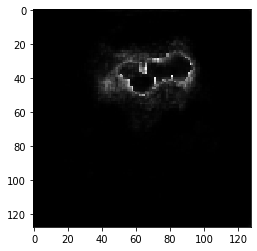

In [308]:
cc = np.array(bb[2].reshape(868,128,128))
print(cc.min(), cc.max())
plt.imshow(cc[255,:,:],cmap='gray')

In [302]:
learn.data.batch_size

In [305]:
print(len(learn.data.batch_stats()))
learn.data.batch_stats()

2


[tensor([-1.2285, -1.1266, -0.8994]), tensor([0.9386, 0.9595, 0.9553])]

In [233]:
str(learn.metrics)

'[<function dice at 0x7fd0cc346a70>]'

In [306]:
#doc(learn.validate)

In [310]:
learn.validate()

[0.059337635, tensor(0.8364)]

In [309]:
learn.validate(learn.data.valid_dl)

[0.059337635, tensor(0.8364)]

In [311]:
learn.validate(dl=learn.data.train_dl)

[0.060997482, tensor(0.8810)]

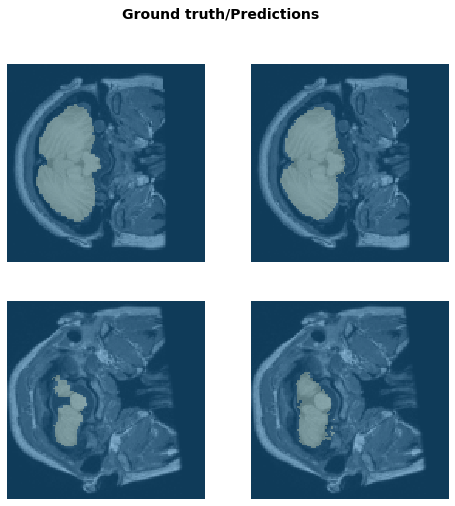

In [237]:
learn.show_results(rows=2)

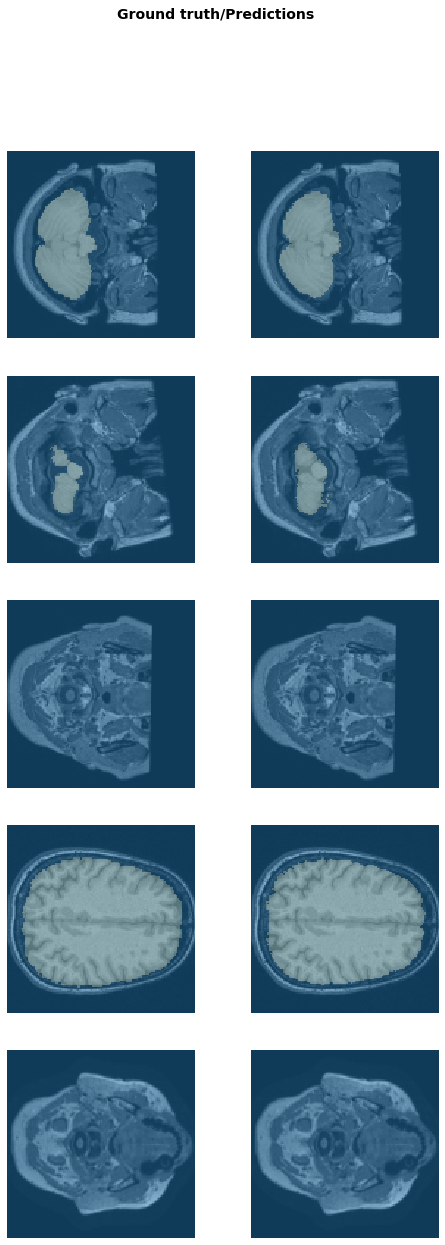

In [238]:
learn.show_results(ds_type=DatasetType.Valid)

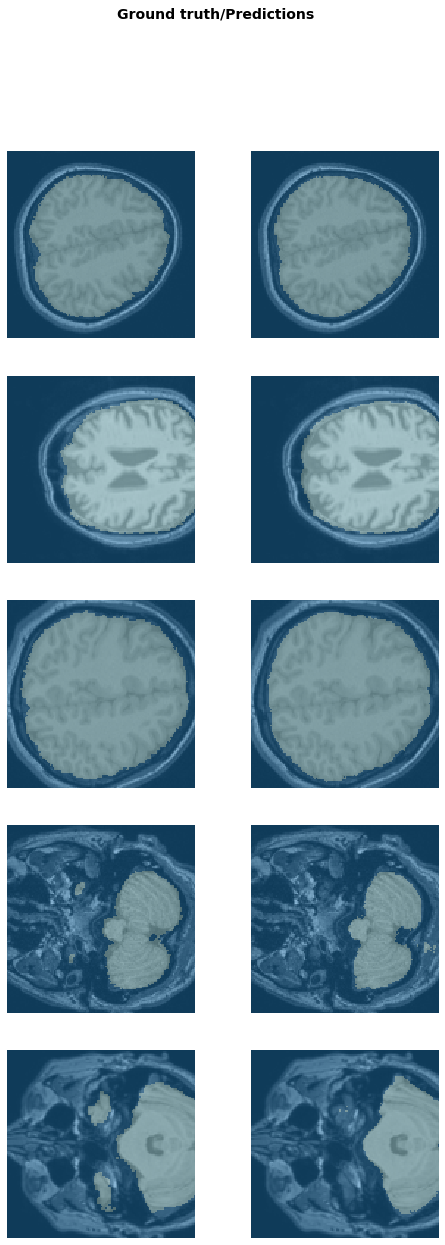

In [239]:
learn.show_results(ds_type=DatasetType.Train,rows=5)

# Infering

## Try to train on original image size 

Very important link to the forum question about this issue: [link](https://forums.fast.ai/t/segmentation-mask-prediction-on-different-input-image-sizes/44389)

#### v3

In [240]:
img = open_image('/data-10tb/shared/skull/axial-2d/train/IXI/IXI002-Guys-0828-T1.anat/T1_biascorr_iso_110.png')

In [241]:
img.shape

torch.Size([3, 180, 240])

In [242]:
#learn.data.train_ds.tfmargs
learn.data.single_dl.dataset.tfmargs['size'] = img.shape

torch.Size([1, 180, 240])


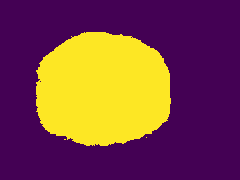

In [244]:
prediction = learn.predict(img)[0]
print(prediction.shape)
prediction

In [245]:
type(prediction)

fastai.vision.image.ImageSegment

In [246]:
prediction.save('xxxx.png')

In [247]:
pwd

'/data-10tb/marek/github_codes/skull-stripping-1/fastai/mk_test'

## Second try to create DataBunch

#### Image List

In [248]:
# item list
il = SegmentationItemList.from_df(df, folder_path, cols='bias_path', convert_mode='L')

In [249]:
il

SegmentationItemList (1277 items)
Image (1, 180, 240),Image (1, 211, 240),Image (1, 176, 256),Image (1, 176, 256),Image (1, 176, 256)
Path: /data-10tb/shared/skull/axial-2d

In [250]:
il.items[0]

'/data-10tb/shared/skull/axial-2d//train/IXI/IXI499-Guys-1004-T1.anat/T1_biascorr_iso_032.png'

In [251]:
defaults.cmap = 'gray'

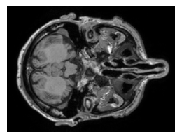

In [252]:
# przeskalowany??? (augumenatation)
il[0].show()

torch.Size([1, 180, 240])


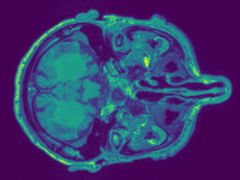

In [253]:
# oryginal???
print(il[0].shape)
il[0]

In [254]:
# split data
sd = il.split_from_df(col='usage')
sd

ItemLists;

Train: SegmentationItemList (983 items)
Image (1, 180, 240),Image (1, 211, 240),Image (1, 176, 256),Image (1, 176, 256),Image (1, 176, 256)
Path: /data-10tb/shared/skull/axial-2d;

Valid: SegmentationItemList (294 items)
Image (1, 176, 256),Image (1, 158, 189),Image (1, 176, 256),Image (1, 176, 240),Image (1, 200, 241)
Path: /data-10tb/shared/skull/axial-2d;

Test: None

In [255]:
# label list
ll = sd.label_from_df(cols='mask_full_path', classes=codes)

In [256]:
ll

LabelLists;

Train: LabelList (983 items)
x: SegmentationItemList
Image (1, 180, 240),Image (1, 211, 240),Image (1, 176, 256),Image (1, 176, 256),Image (1, 176, 256)
y: SegmentationLabelList
ImageSegment (1, 180, 240),ImageSegment (1, 211, 240),ImageSegment (1, 176, 256),ImageSegment (1, 176, 256),ImageSegment (1, 176, 256)
Path: /data-10tb/shared/skull/axial-2d;

Valid: LabelList (294 items)
x: SegmentationItemList
Image (1, 176, 256),Image (1, 158, 189),Image (1, 176, 256),Image (1, 176, 240),Image (1, 200, 241)
y: SegmentationLabelList
ImageSegment (1, 176, 256),ImageSegment (1, 158, 189),ImageSegment (1, 176, 256),ImageSegment (1, 176, 240),ImageSegment (1, 200, 241)
Path: /data-10tb/shared/skull/axial-2d;

Test: None

In [257]:
x,y = ll.train[0]

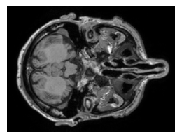

In [258]:
x.show()

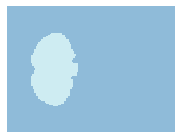

In [259]:
y.show()

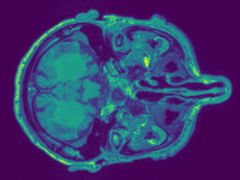

In [260]:
x

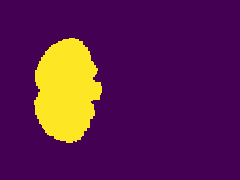

In [261]:
y

In [262]:
# orginalne wielkosci
print(x.shape, y.shape)

torch.Size([1, 180, 240]) torch.Size([1, 180, 240])


In [263]:
# transformed labeled list, 
# [] - not transform for a validation set
tmfs = ([*rand_pad(padding=3, size=128, mode='zeros')], [])
ll = ll.transform(tmfs, tfm_y=True)

In [264]:
bs=128
data = ll.databunch(bs=bs).normalize(imagenet_stats)

In [265]:
x,y = data.train_ds[0]

In [266]:
print(x.shape, y.shape)

torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


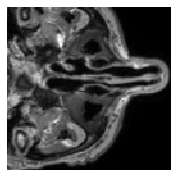

In [267]:
x.show()

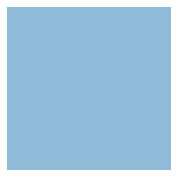

In [268]:
y.show()

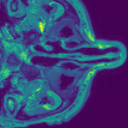

In [269]:
x

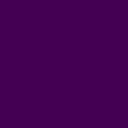

In [270]:
y

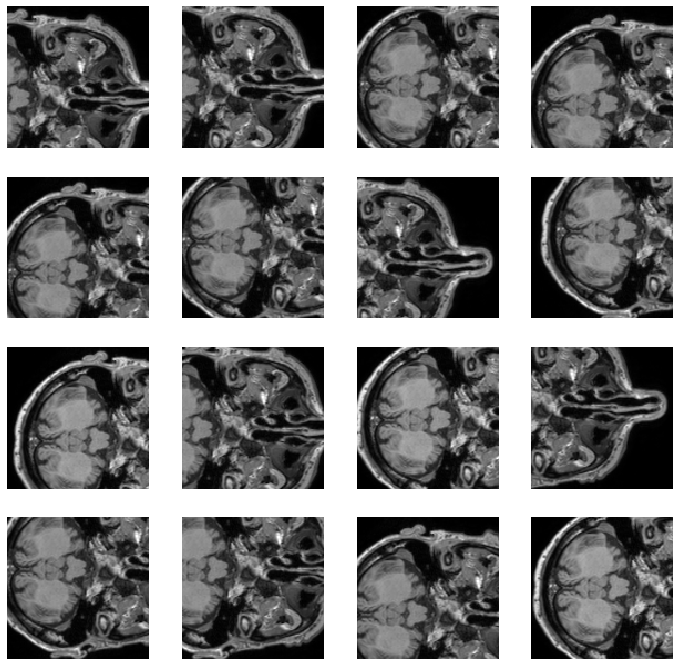

In [271]:
# load image[0][0] from a disc, and transform it on the fly!!! (the same image!!!)
def _plot(i,j,ax):data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 4,4, figsize=(12,12))

### get one batch

In [273]:
xb, yb = data.one_batch()

In [274]:
print(xb.shape, yb.shape)

torch.Size([128, 3, 128, 128]) torch.Size([128, 1, 128, 128])


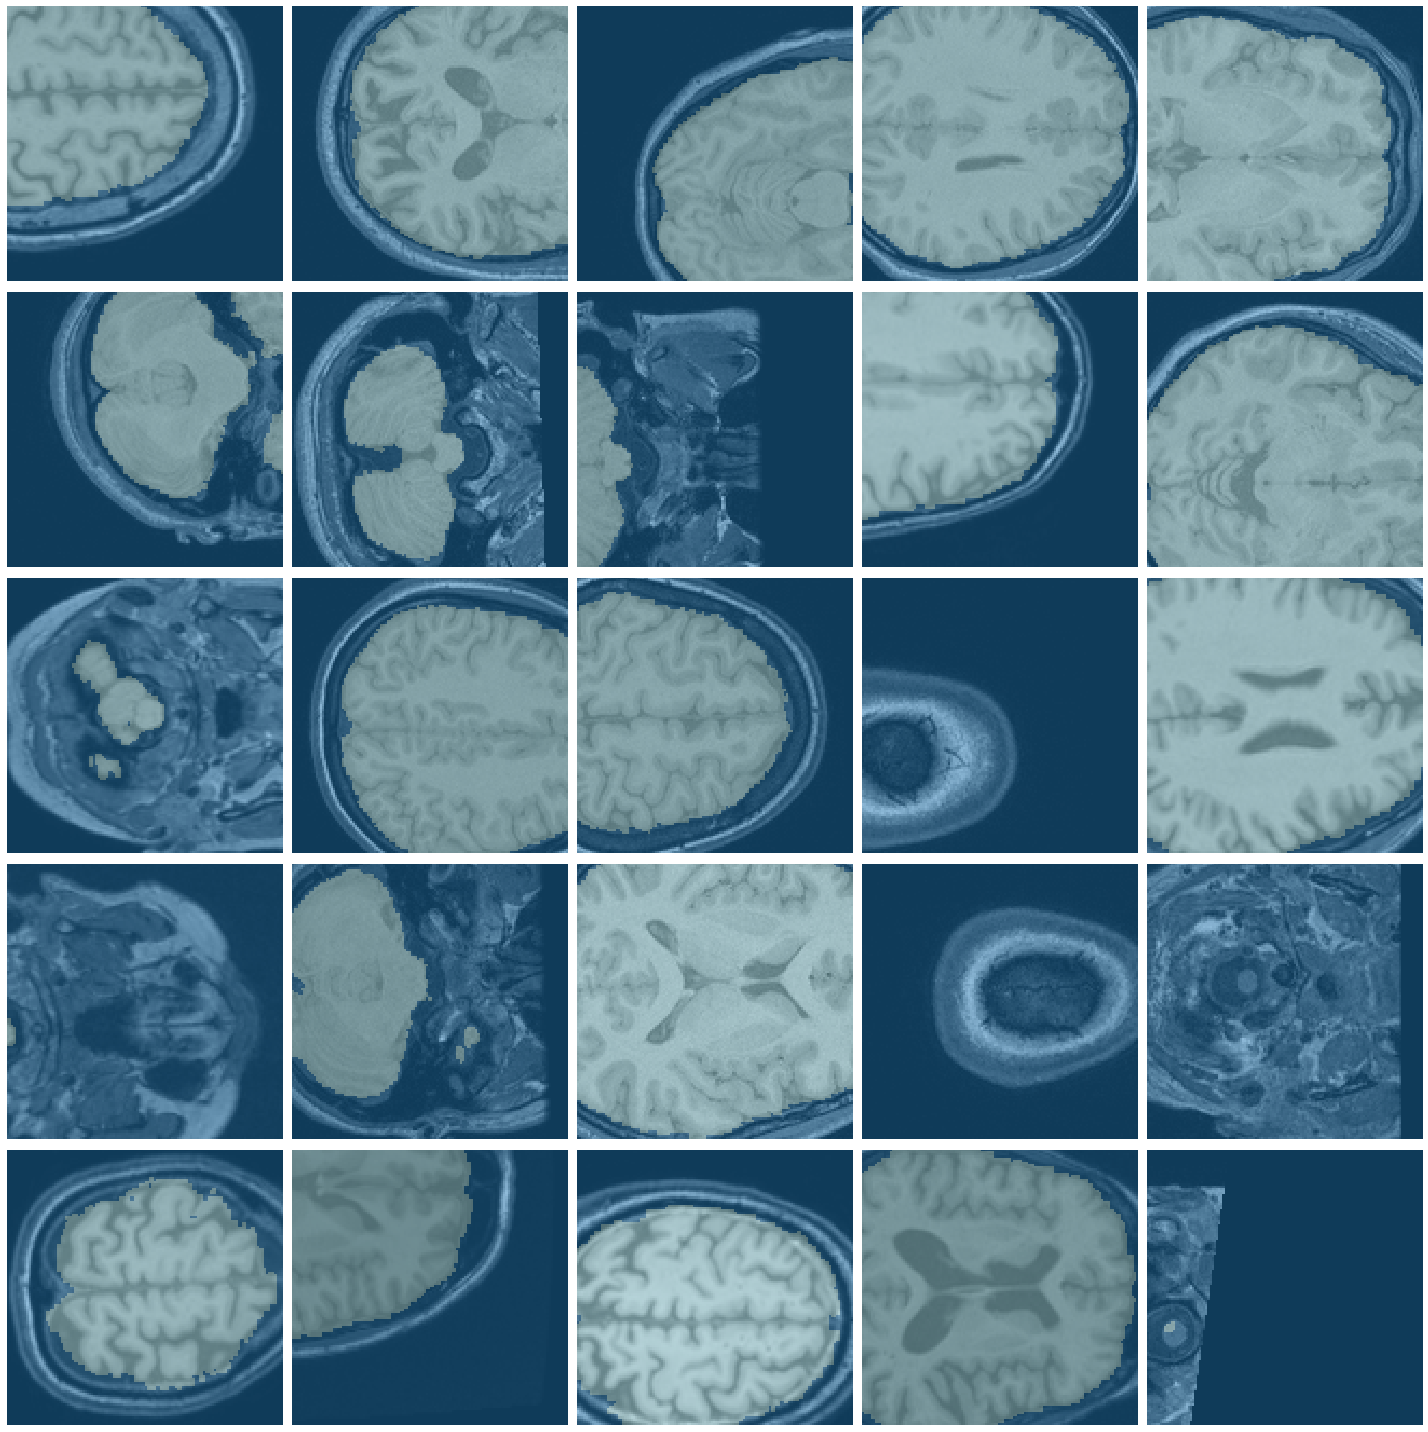

In [275]:
data.show_batch()

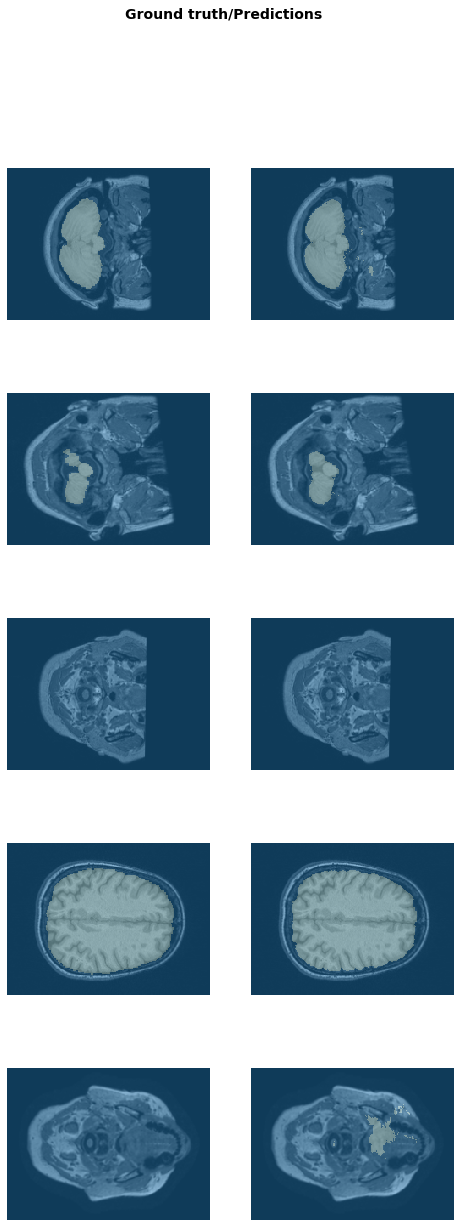

In [276]:
learn.show_results()

SyntaxError: invalid syntax (<ipython-input-19-6421d1936512>, line 1)

In [20]:
# show_image(data.train_ds[1100][0])
# show_image(data.train_ds[1100][1])
# data.train_ds[1100][1].show()
# data.train_ds[1100][0].show()
# data.train_ds[1100][0]